In [0]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!unzip images.zip

In [0]:
class ShootingStarNet(nn.Module):
  def __init__(self, p=0.5):
    super(ShootingStarNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 128 -> 64
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 64 -> 32
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 32 -> 16
    self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # 16 -> 8
    self.conv5 = nn.Conv2d(256, 512, 3, padding=1) # 8 -> 4
    self.fc1 = nn.Linear(4 * 4 * 512, 4096)
    self.fc2 = nn.Linear(4096, 2048)
    self.fc3 = nn.Linear(2048, 1024)
    self.fc4 = nn.Linear(1024, 256)
    self.fc5 = nn.Linear(256 + 4, 128)
    self.fc6 = nn.Linear(128, 64)
    self.fc7 = nn.Linear(64, 8)
    self.drop1 = nn.Dropout(p)

  def forward(self, x):
    config_states, maps = x
    maps = maps.unsqueeze(1).float().to("cuda")
    config_states = config_states.float().to("cuda")
    x = F.max_pool2d(F.relu(self.conv1(maps)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    x = F.max_pool2d(F.relu(self.conv4(x)), 2)
    x = F.max_pool2d(F.relu(self.conv5(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.drop1(x)
    x = F.relu(self.fc4(x))
    x = self.drop1(x)
    x = torch.cat((x, config_states), axis=1)
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [0]:
from dataloader import HolonomicDataset
from torch.utils.data import DataLoader
path = './'
dataset = HolonomicDataset('data.csv', path, grayscale=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [0]:
net = ShootingStarNet().to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
JHist = []

In [0]:
for j in range(100):
  for i, (input_data, labels) in enumerate(dataloader):

    y_label = labels.to("cuda")
    y_label = y_label - 1
    optimizer.zero_grad()
    y_pred = net(input_data)
    loss = criterion(y_pred, y_label)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    JHist.append(epoch_loss)
    
    print(i + j * 123, epoch_loss)

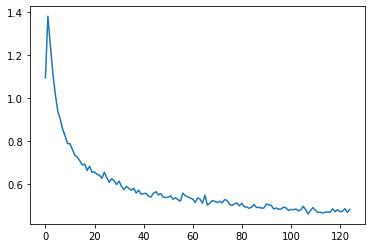

In [14]:
import matplotlib.pyplot as plt
JHist_avg = []
sum = 0
for index in range(30, len(JHist)):
  sum += JHist[index]
  if index % 99 == 0:
    JHist_avg.append(sum / 100)
    sum = 0

plt.plot(JHist_avg)

In [15]:
# check labels on all of training data
correct = 0
total = 0
for i, (input_data, labels) in enumerate(dataloader):
  test_input = input_data
  test_label = labels.to("cuda")

  y_pred = net(test_input)
  pred_actions = torch.argmax(y_pred, axis=1)
  
  total += pred_actions.shape[0]
  for j in range(pred_actions.shape[0]):
    if pred_actions[j] == test_label[j] - 1:
      correct += 1
print(correct / total)

0.7909206349206349


In [0]:
from google.colab import files
PATH = './ShootingStarNet.pth'
torch.save(net.state_dict(), PATH)
files.download(PATH)